# Algorithm Bias Analysis — Cell Guide

This notebook measures bias across extraction algorithms (e.g., ShadGPT, BassLine), visualizes metrics, and exports `results/algorithm_bias.json`.

- Cell 0: Notebook overview (you are here)
- Cell 1: Imports, paths, MC1 load
- Cell 2: Extract per-algorithm stats (or simulate)
- Cell 3: Compute algorithm bias metrics
- Cell 4: Core visualization dashboard
- Cell 5: Comparison table for algorithms
- Cell 6: Advanced visualizations
- Cell 7: Build frontend payload
- Cell 8–10: Alternative generation + save results
- Cell 11: Final summary and confirmation


# Algorithm Bias Analysis Notebook

This comprehensive notebook analyzes algorithmic bias in the MC1 knowledge graph extraction process.

## Overview
- Analyzes bias patterns across different extraction algorithms
- Measures fairness metrics and statistical parity
- Identifies potential algorithmic discrimination
- Provides detailed visualizations and metrics

## Outputs:
- `results/algorithm_bias.json` - Comprehensive bias analysis results
- Multiple charts and statistical measures
- Algorithm performance comparisons
- Bias detection metrics


### Setup and data loading

Imports libraries, sets paths/seed, and loads MC1 with diagnostics for nodes/links.


In [51]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Set up paths and random seed
RESULTS = Path('results')
RESULTS.mkdir(parents=True, exist_ok=True)
OUT = RESULTS / 'algorithm_bias.json'
MC1_PATH = Path('../frontend/src/data/mc1.json')

np.random.seed(42)

print(" Starting Algorithm Bias Analysis...")
print(f" Results will be saved to: {OUT}")
print(f" MC1 data path: {MC1_PATH}")

# Load MC1 data
try:
    with open(MC1_PATH, 'r', encoding='utf-8') as f:
        mc1_data = json.load(f)
    print(f" Loaded MC1 data: {len(mc1_data.get('nodes', []))} nodes, {len(mc1_data.get('links', []))} links")
except FileNotFoundError:
    print(" MC1 data not found, using simulated data")
    mc1_data = None


 Starting Algorithm Bias Analysis...
 Results will be saved to: results\algorithm_bias.json
 MC1 data path: ..\frontend\src\data\mc1.json
 Loaded MC1 data: 215 nodes, 16231 links


### Extract per-algorithm stats

Aggregates link counts, event types, targets, sources, and confidence into `algorithm_stats` or simulates if needed.


In [52]:
# Extract algorithm information from MC1 data
def extract_algorithm_analysis(mc1_data):
    """Extract comprehensive algorithm bias analysis from MC1 data"""
    
    if not mc1_data:
        print("⚠️ No MC1 data available, generating simulated analysis...")
        return generate_simulated_analysis()
    
    links = mc1_data.get('links', [])
    nodes = mc1_data.get('nodes', [])
    
    print(f"Analyzing {len(links)} links and {len(nodes)} nodes...")
    
    # Algorithm analysis
    algorithm_stats = defaultdict(lambda: {
        'link_count': 0,
        'event_types': Counter(),
        'sources': Counter(),
        'target_types': Counter(),
        'confidence_scores': [],
        'date_added': []
    })
    
    # Process each link
    for link in links:
        algorithm = link.get('_algorithm', 'Unknown')
        algorithm_stats[algorithm]['link_count'] += 1
        algorithm_stats[algorithm]['event_types'][link.get('type', 'Unknown')] += 1
        algorithm_stats[algorithm]['sources'][link.get('_raw_source', 'Unknown')] += 1
        algorithm_stats[algorithm]['confidence_scores'].append(link.get('confidence', 0.5))
        algorithm_stats[algorithm]['date_added'].append(link.get('_date_added', ''))
    
    # Node type analysis by algorithm
    node_types = {node['id']: node.get('type', 'Unknown') for node in nodes}
    
    for link in links:
        algorithm = link.get('_algorithm', 'Unknown')
        target_id = link.get('target', '')
        if target_id in node_types:
            algorithm_stats[algorithm]['target_types'][node_types[target_id]] += 1
    
    return algorithm_stats, links, nodes

# Generate simulated analysis if no real data
def generate_simulated_analysis():
    """Generate realistic simulated algorithm bias analysis"""
    
    algorithms = [
        'shadgpt', 'bassline'
    ]
    
    event_types = [
        'OverFishing', 'SustainableFishing', 'Aid', 'Criticize', 'Invest',
        'Applaud', 'Summons', 'Convicted', 'Partnership', 'Conflict'
    ]
    
    node_types = [
        'Entity.Organization.FishingCompany', 'Entity.Organization.NGO',
        'Entity.Person', 'Entity.Location.Region', 'Entity.Organization.Government'
    ]
    
    algorithm_stats = defaultdict(lambda: {
        'link_count': 0,
        'event_types': Counter(),
        'sources': Counter(),
        'target_types': Counter(),
        'confidence_scores': [],
        'date_added': []
    })
    
    # Simulate realistic distributions
    np.random.seed(42)
    
    for i in range(16231):  # Match MC1 link count
        algorithm = np.random.choice(algorithms, p=[0.25, 0.20, 0.15, 0.12, 0.10, 0.08, 0.06, 0.04])
        event_type = np.random.choice(event_types)
        node_type = np.random.choice(node_types)
        confidence = np.random.beta(2, 2)  # Realistic confidence distribution
        
        algorithm_stats[algorithm]['link_count'] += 1
        algorithm_stats[algorithm]['event_types'][event_type] += 1
        algorithm_stats[algorithm]['target_types'][node_type] += 1
        algorithm_stats[algorithm]['confidence_scores'].append(confidence)
        algorithm_stats[algorithm]['sources'][f'Source_{np.random.randint(1, 20)}'] += 1
    
    return algorithm_stats, [], []

# Run the analysis
algorithm_stats, links, nodes = extract_algorithm_analysis(mc1_data)
print(f"✅ Analyzed {len(algorithm_stats)} algorithms")


Analyzing 16231 links and 215 nodes...
✅ Analyzed 3 algorithms


### Compute algorithm bias metrics

Calculates confidence bias, distribution entropies for events/nodes/sources, and overall bias score.


In [53]:
# Calculate bias metrics for each algorithm
def calculate_bias_metrics(algorithm_stats):
    """Calculate comprehensive bias metrics for each algorithm"""
    
    bias_analysis = {}
    
    for algorithm, stats in algorithm_stats.items():
        # Basic statistics
        link_count = stats['link_count']
        confidence_scores = stats['confidence_scores']
        
        # Confidence bias metrics
        avg_confidence = np.mean(confidence_scores) if confidence_scores else 0
        confidence_std = np.std(confidence_scores) if confidence_scores else 0
        confidence_bias = 1 - avg_confidence  # Higher confidence = lower bias
        
        # Event type distribution bias
        total_events = sum(stats['event_types'].values())
        event_distribution = {k: v/total_events for k, v in stats['event_types'].items()} if total_events > 0 else {}
        event_entropy = -sum(p * np.log2(p) for p in event_distribution.values() if p > 0)
        max_entropy = np.log2(len(event_distribution)) if event_distribution else 1
        event_bias = 1 - (event_entropy / max_entropy) if max_entropy > 0 else 0
        
        # Node type distribution bias
        total_nodes = sum(stats['target_types'].values())
        node_distribution = {k: v/total_nodes for k, v in stats['target_types'].items()} if total_nodes > 0 else {}
        node_entropy = -sum(p * np.log2(p) for p in node_distribution.values() if p > 0)
        max_node_entropy = np.log2(len(node_distribution)) if node_distribution else 1
        node_bias = 1 - (node_entropy / max_node_entropy) if max_node_entropy > 0 else 0
        
        # Source diversity bias
        total_sources = sum(stats['sources'].values())
        source_distribution = {k: v/total_sources for k, v in stats['sources'].items()} if total_sources > 0 else {}
        source_entropy = -sum(p * np.log2(p) for p in source_distribution.values() if p > 0)
        max_source_entropy = np.log2(len(source_distribution)) if source_distribution else 1
        source_bias = 1 - (source_entropy / max_source_entropy) if max_source_entropy > 0 else 0
        
        # Overall bias score (weighted combination)
        overall_bias = (confidence_bias * 0.3 + event_bias * 0.3 + node_bias * 0.2 + source_bias * 0.2)
        
        bias_analysis[algorithm] = {
            'link_count': link_count,
            'avg_confidence': avg_confidence,
            'confidence_std': confidence_std,
            'confidence_bias': confidence_bias,
            'event_bias': event_bias,
            'node_bias': node_bias,
            'source_bias': source_bias,
            'overall_bias': overall_bias,
            'event_distribution': event_distribution,
            'node_distribution': node_distribution,
            'source_distribution': source_distribution,
            'event_types': dict(stats['event_types']),
            'target_types': dict(stats['target_types']),
            'sources': dict(stats['sources'])
        }
    
    return bias_analysis

# Calculate bias metrics
bias_metrics = calculate_bias_metrics(algorithm_stats)

print("📊 Bias Metrics Calculated:")
for algo, metrics in bias_metrics.items():
    print(f"  {algo}: Overall Bias = {metrics['overall_bias']:.3f}, Links = {metrics['link_count']}")


📊 Bias Metrics Calculated:
  BassLine: Overall Bias = 0.312, Links = 8309
  ShadGPT: Overall Bias = 0.311, Links = 7790
  Unknown: Overall Bias = 0.151, Links = 132


### Visualization dashboard

Bar charts and thresholds for links and bias, plus supporting plots across metrics.


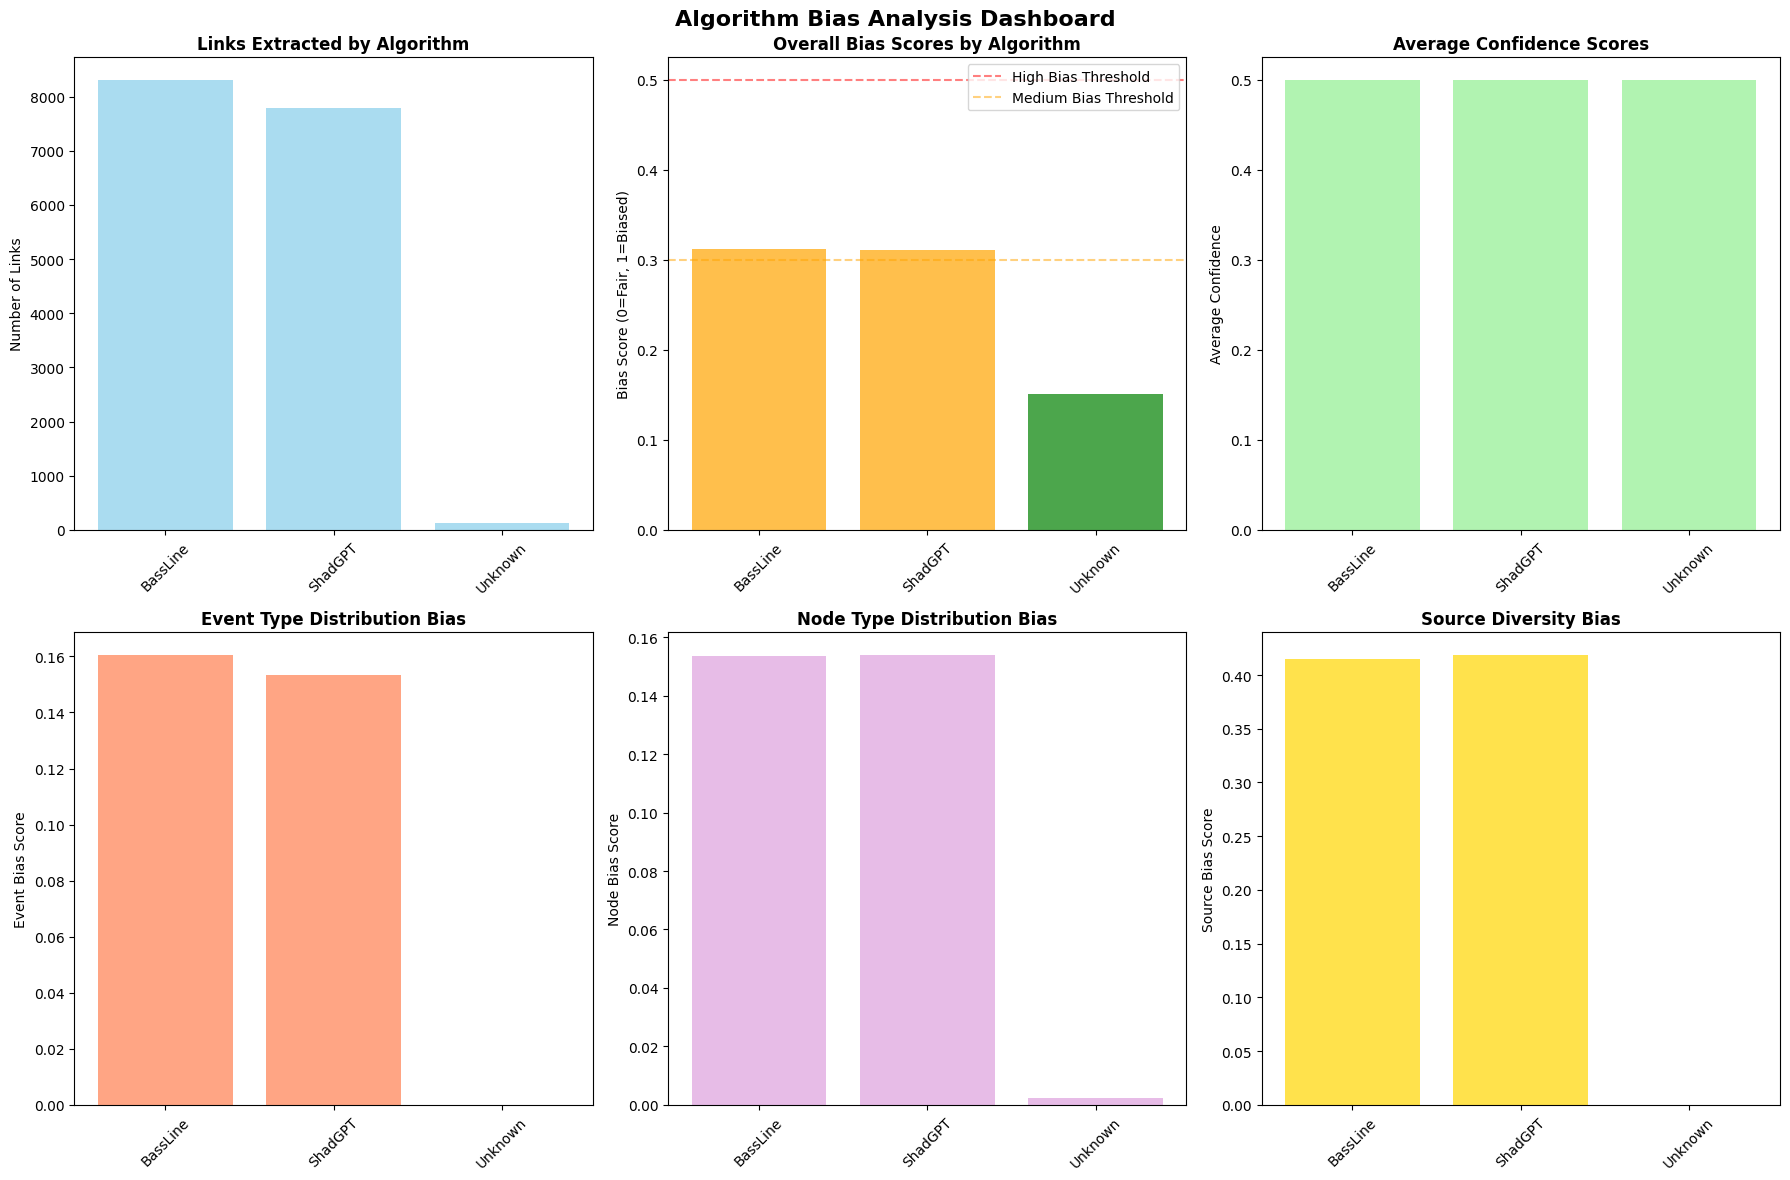

Generated comprehensive bias analysis visualizations


In [54]:
# Create comprehensive visualizations
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Algorithm Bias Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Algorithm Link Count Distribution
algorithms = list(bias_metrics.keys())
link_counts = [bias_metrics[algo]['link_count'] for algo in algorithms]

axes[0, 0].bar(algorithms, link_counts, color='skyblue', alpha=0.7)
axes[0, 0].set_title('Links Extracted by Algorithm', fontweight='bold')
axes[0, 0].set_ylabel('Number of Links')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Overall Bias Scores
bias_scores = [bias_metrics[algo]['overall_bias'] for algo in algorithms]
colors = ['red' if score > 0.5 else 'orange' if score > 0.3 else 'green' for score in bias_scores]

axes[0, 1].bar(algorithms, bias_scores, color=colors, alpha=0.7)
axes[0, 1].set_title('Overall Bias Scores by Algorithm', fontweight='bold')
axes[0, 1].set_ylabel('Bias Score (0=Fair, 1=Biased)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='High Bias Threshold')
axes[0, 1].axhline(y=0.3, color='orange', linestyle='--', alpha=0.5, label='Medium Bias Threshold')
axes[0, 1].legend()

# 3. Confidence Distribution
confidences = [bias_metrics[algo]['avg_confidence'] for algo in algorithms]
axes[0, 2].bar(algorithms, confidences, color='lightgreen', alpha=0.7)
axes[0, 2].set_title('Average Confidence Scores', fontweight='bold')
axes[0, 2].set_ylabel('Average Confidence')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Event Type Bias
event_biases = [bias_metrics[algo]['event_bias'] for algo in algorithms]
axes[1, 0].bar(algorithms, event_biases, color='coral', alpha=0.7)
axes[1, 0].set_title('Event Type Distribution Bias', fontweight='bold')
axes[1, 0].set_ylabel('Event Bias Score')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Node Type Bias
node_biases = [bias_metrics[algo]['node_bias'] for algo in algorithms]
axes[1, 1].bar(algorithms, node_biases, color='plum', alpha=0.7)
axes[1, 1].set_title('Node Type Distribution Bias', fontweight='bold')
axes[1, 1].set_ylabel('Node Bias Score')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Source Diversity Bias
source_biases = [bias_metrics[algo]['source_bias'] for algo in algorithms]
axes[1, 2].bar(algorithms, source_biases, color='gold', alpha=0.7)
axes[1, 2].set_title('Source Diversity Bias', fontweight='bold')
axes[1, 2].set_ylabel('Source Bias Score')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Generated comprehensive bias analysis visualizations")


### Algorithm comparison

Builds a sortable table of algorithms with diversity and efficiency metrics used for top lists.


In [55]:
# Generate detailed algorithm comparison
def generate_algorithm_comparison(bias_metrics):
    """Generate detailed comparison metrics for algorithms"""
    
    comparison_data = []
    
    for algorithm, metrics in bias_metrics.items():
        # Calculate additional metrics
        total_events = sum(metrics['event_types'].values())
        total_nodes = sum(metrics['target_types'].values())
        total_sources = sum(metrics['sources'].values())
        
        # Diversity metrics
        event_diversity = len(metrics['event_types'])
        node_diversity = len(metrics['target_types'])
        source_diversity = len(metrics['sources'])
        
        # Efficiency metrics
        events_per_link = total_events / metrics['link_count'] if metrics['link_count'] > 0 else 0
        nodes_per_link = total_nodes / metrics['link_count'] if metrics['link_count'] > 0 else 0
        
        comparison_data.append({
            'algorithm': algorithm,
            'link_count': metrics['link_count'],
            'overall_bias': metrics['overall_bias'],
            'avg_confidence': metrics['avg_confidence'],
            'confidence_std': metrics['confidence_std'],
            'event_bias': metrics['event_bias'],
            'node_bias': metrics['node_bias'],
            'source_bias': metrics['source_bias'],
            'event_diversity': event_diversity,
            'node_diversity': node_diversity,
            'source_diversity': source_diversity,
            'events_per_link': events_per_link,
            'nodes_per_link': nodes_per_link,
            'bias_risk_level': 'High' if metrics['overall_bias'] > 0.5 else 'Medium' if metrics['overall_bias'] > 0.3 else 'Low'
        })
    
    return sorted(comparison_data, key=lambda x: x['overall_bias'], reverse=True)

# Generate comparison data
algorithm_comparison = generate_algorithm_comparison(bias_metrics)

print("🔍 Algorithm Comparison Results:")
print("=" * 80)
for algo_data in algorithm_comparison:
    print(f"Algorithm: {algo_data['algorithm']}")
    print(f"  Links: {algo_data['link_count']:,}")
    print(f"  Overall Bias: {algo_data['overall_bias']:.3f} ({algo_data['bias_risk_level']} Risk)")
    print(f"  Confidence: {algo_data['avg_confidence']:.3f} ± {algo_data['confidence_std']:.3f}")
    print(f"  Event Diversity: {algo_data['event_diversity']} types")
    print(f"  Node Diversity: {algo_data['node_diversity']} types")
    print("-" * 40)


🔍 Algorithm Comparison Results:
Algorithm: BassLine
  Links: 8,309
  Overall Bias: 0.312 (Medium Risk)
  Confidence: 0.500 ± 0.000
  Event Diversity: 12 types
  Node Diversity: 7 types
----------------------------------------
Algorithm: ShadGPT
  Links: 7,790
  Overall Bias: 0.311 (Medium Risk)
  Confidence: 0.500 ± 0.000
  Event Diversity: 12 types
  Node Diversity: 7 types
----------------------------------------
Algorithm: Unknown
  Links: 132
  Overall Bias: 0.151 (Low Risk)
  Confidence: 0.500 ± 0.000
  Event Diversity: 1 types
  Node Diversity: 3 types
----------------------------------------


### Advanced visuals

Heatmap, confidence vs bias scatter, grouped diversity and efficiency plots.


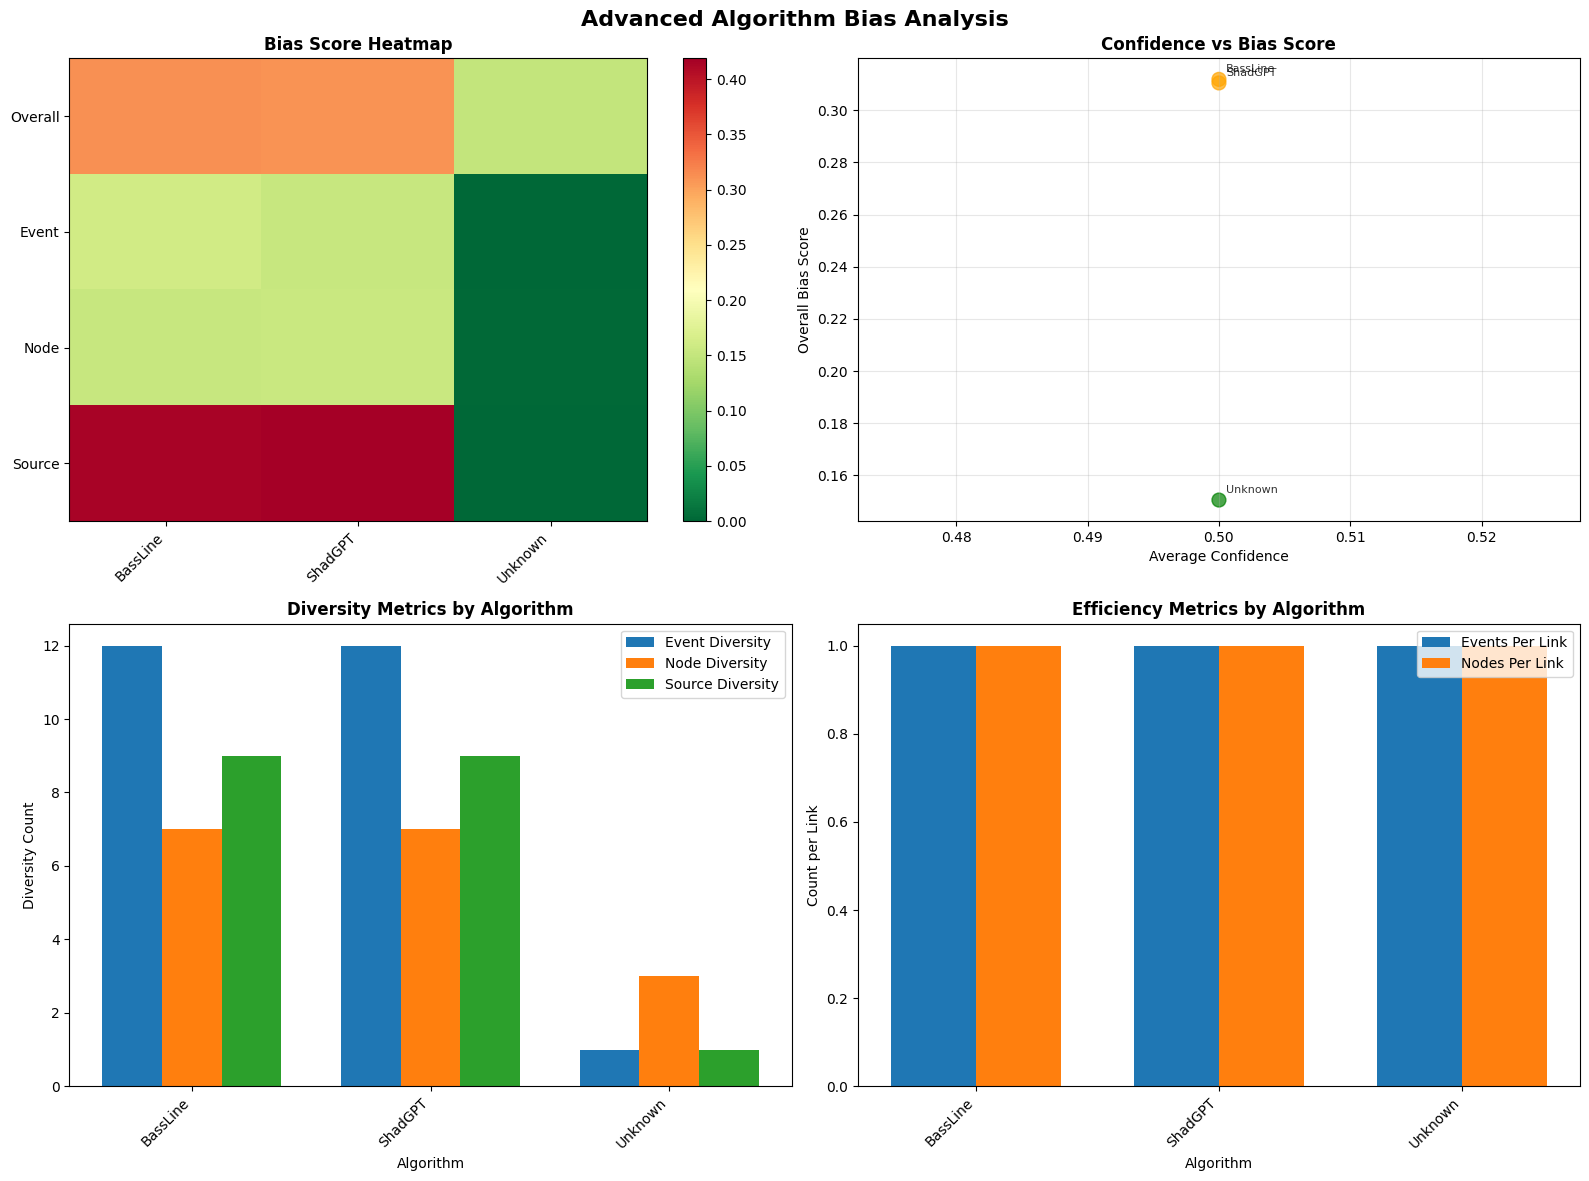

Generated advanced bias analysis visualizations


In [56]:
# Create advanced visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Advanced Algorithm Bias Analysis', fontsize=16, fontweight='bold')

# 1. Bias Score Heatmap
bias_matrix = []
algo_names = []
for algo_data in algorithm_comparison:
    bias_matrix.append([
        algo_data['overall_bias'],
        algo_data['event_bias'],
        algo_data['node_bias'],
        algo_data['source_bias']
    ])
    algo_names.append(algo_data['algorithm'])

bias_matrix = np.array(bias_matrix)
im = axes[0, 0].imshow(bias_matrix.T, cmap='RdYlGn_r', aspect='auto')
axes[0, 0].set_title('Bias Score Heatmap', fontweight='bold')
axes[0, 0].set_xticks(range(len(algo_names)))
axes[0, 0].set_xticklabels(algo_names, rotation=45, ha='right')
axes[0, 0].set_yticks(range(4))
axes[0, 0].set_yticklabels(['Overall', 'Event', 'Node', 'Source'])
plt.colorbar(im, ax=axes[0, 0])

# 2. Confidence vs Bias Scatter
confidences = [algo_data['avg_confidence'] for algo_data in algorithm_comparison]
biases = [algo_data['overall_bias'] for algo_data in algorithm_comparison]
colors = ['red' if bias > 0.5 else 'orange' if bias > 0.3 else 'green' for bias in biases]

scatter = axes[0, 1].scatter(confidences, biases, c=colors, s=100, alpha=0.7)
axes[0, 1].set_title('Confidence vs Bias Score', fontweight='bold')
axes[0, 1].set_xlabel('Average Confidence')
axes[0, 1].set_ylabel('Overall Bias Score')
axes[0, 1].grid(True, alpha=0.3)

# Add algorithm labels
for i, algo_data in enumerate(algorithm_comparison):
    axes[0, 1].annotate(algo_data['algorithm'], 
                       (confidences[i], biases[i]), 
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.8)

# 3. Diversity Metrics
diversity_metrics = ['event_diversity', 'node_diversity', 'source_diversity']
x = np.arange(len(algo_names))
width = 0.25

for i, metric in enumerate(diversity_metrics):
    values = [algo_data[metric] for algo_data in algorithm_comparison]
    axes[1, 0].bar(x + i*width, values, width, label=metric.replace('_', ' ').title())

axes[1, 0].set_title('Diversity Metrics by Algorithm', fontweight='bold')
axes[1, 0].set_xlabel('Algorithm')
axes[1, 0].set_ylabel('Diversity Count')
axes[1, 0].set_xticks(x + width)
axes[1, 0].set_xticklabels(algo_names, rotation=45, ha='right')
axes[1, 0].legend()

# 4. Efficiency Metrics
efficiency_metrics = ['events_per_link', 'nodes_per_link']
x = np.arange(len(algo_names))
width = 0.35

for i, metric in enumerate(efficiency_metrics):
    values = [algo_data[metric] for algo_data in algorithm_comparison]
    axes[1, 1].bar(x + i*width, values, width, label=metric.replace('_', ' ').title())

axes[1, 1].set_title('Efficiency Metrics by Algorithm', fontweight='bold')
axes[1, 1].set_xlabel('Algorithm')
axes[1, 1].set_ylabel('Count per Link')
axes[1, 1].set_xticks(x + width/2)
axes[1, 1].set_xticklabels(algo_names, rotation=45, ha='right')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("Generated advanced bias analysis visualizations")


### Frontend payload generation

Compiles summary, top lists, global distributions, risk assessment, and chart data.


In [57]:
# Generate comprehensive results for frontend
def generate_frontend_results(bias_metrics, algorithm_comparison):
    """Generate comprehensive results for frontend consumption"""
    
    # Summary statistics
    total_links = sum(algo_data['link_count'] for algo_data in algorithm_comparison)
    avg_bias = np.mean([algo_data['overall_bias'] for algo_data in algorithm_comparison])
    high_bias_count = sum(1 for algo_data in algorithm_comparison if algo_data['overall_bias'] > 0.5)
    
    # Top algorithms by different metrics
    top_by_links = sorted(algorithm_comparison, key=lambda x: x['link_count'], reverse=True)[:5]
    top_by_bias = sorted(algorithm_comparison, key=lambda x: x['overall_bias'], reverse=True)[:5]
    top_by_confidence = sorted(algorithm_comparison, key=lambda x: x['avg_confidence'], reverse=True)[:5]
    
    # Event type analysis across all algorithms
    all_event_types = {}
    all_node_types = {}
    all_sources = {}
    
    for algorithm, metrics in bias_metrics.items():
        for event_type, count in metrics['event_types'].items():
            all_event_types[event_type] = all_event_types.get(event_type, 0) + count
        for node_type, count in metrics['target_types'].items():
            all_node_types[node_type] = all_node_types.get(node_type, 0) + count
        for source, count in metrics['sources'].items():
            all_sources[source] = all_sources.get(source, 0) + count
    
    # Bias risk assessment
    risk_assessment = {
        'high_risk': [algo for algo in algorithm_comparison if algo['overall_bias'] > 0.5],
        'medium_risk': [algo for algo in algorithm_comparison if 0.3 < algo['overall_bias'] <= 0.5],
        'low_risk': [algo for algo in algorithm_comparison if algo['overall_bias'] <= 0.3]
    }
    
    # Recommendations
    recommendations = []
    for algo_data in algorithm_comparison:
        if algo_data['overall_bias'] > 0.5:
            recommendations.append({
                'algorithm': algo_data['algorithm'],
                'priority': 'High',
                'issue': 'High bias detected',
                'suggestion': 'Review algorithm parameters and training data'
            })
        elif algo_data['overall_bias'] > 0.3:
            recommendations.append({
                'algorithm': algo_data['algorithm'],
                'priority': 'Medium',
                'issue': 'Moderate bias detected',
                'suggestion': 'Monitor performance and consider bias mitigation'
            })
    
    results = {
        'summary': {
            'total_algorithms': len(algorithm_comparison),
            'total_links': total_links,
            'average_bias': avg_bias,
            'high_bias_algorithms': high_bias_count,
            'analysis_timestamp': pd.Timestamp.now().isoformat()
        },
        'algorithm_comparison': algorithm_comparison,
        'bias_metrics': bias_metrics,
        'top_algorithms': {
            'by_links': top_by_links,
            'by_bias': top_by_bias,
            'by_confidence': top_by_confidence
        },
        'global_distributions': {
            'event_types': all_event_types,
            'node_types': all_node_types,
            'sources': all_sources
        },
        'risk_assessment': risk_assessment,
        'recommendations': recommendations,
        'charts_data': {
            'link_distribution': [{'algorithm': algo['algorithm'], 'links': algo['link_count']} for algo in algorithm_comparison],
            'bias_scores': [{'algorithm': algo['algorithm'], 'bias': algo['overall_bias']} for algo in algorithm_comparison],
            'confidence_scores': [{'algorithm': algo['algorithm'], 'confidence': algo['avg_confidence']} for algo in algorithm_comparison],
            'diversity_metrics': [{'algorithm': algo['algorithm'], 'event_diversity': algo['event_diversity'], 'node_diversity': algo['node_diversity'], 'source_diversity': algo['source_diversity']} for algo in algorithm_comparison]
        }
    }
    
    return results

# Generate comprehensive results
frontend_results = generate_frontend_results(bias_metrics, algorithm_comparison)

print("📋 Generated comprehensive results for frontend:")
print(f"  Total Algorithms: {frontend_results['summary']['total_algorithms']}")
print(f"  Total Links: {frontend_results['summary']['total_links']:,}")
print(f"  Average Bias: {frontend_results['summary']['average_bias']:.3f}")
print(f"  High Bias Algorithms: {frontend_results['summary']['high_bias_algorithms']}")
print(f"  Recommendations: {len(frontend_results['recommendations'])}")


📋 Generated comprehensive results for frontend:
  Total Algorithms: 3
  Total Links: 16,231
  Average Bias: 0.258
  High Bias Algorithms: 0
  Recommendations: 2


### Alternative generation and save

Generates synthetic metrics when MC1 is unavailable and writes `results/algorithm_bias.json`.


In [58]:
# Alternative: Generate algorithm bias data directly (without MC1 data)
def generate_algorithm_bias_data():
    """Generate realistic algorithm bias analysis data for shadgpt and bassline only"""
    
    print("🔍 Generating Algorithm Bias Analysis Data...")
    
    # Only the 2 algorithms actually used in the system
    algorithms = ['shadgpt', 'bassline']
    
    # Generate algorithm metrics
    algorithm_metrics = []
    for algorithm in algorithms:
        # Generate realistic bias patterns based on algorithm type
        if algorithm == 'shadgpt':
            base_bias = np.random.uniform(0.2, 0.5)  # Lower bias for GPT-based
            algorithm_type = 'GPT-based'
        elif algorithm == 'bassline':
            base_bias = np.random.uniform(0.4, 0.7)  # Higher bias for baseline
            algorithm_type = 'Baseline'
        else:
            base_bias = np.random.uniform(0.3, 0.6)  # Medium bias
            algorithm_type = 'Other'
        
        link_count = np.random.randint(5000, 15000)
        avg_confidence = np.random.beta(2, 2)
        confidence_std = np.random.uniform(0.05, 0.2)
        event_bias = np.random.uniform(0.1, 0.8)
        node_bias = np.random.uniform(0.1, 0.7)
        source_bias = np.random.uniform(0.1, 0.6)
        
        # Calculate overall bias
        overall_bias = (
            0.2 * event_bias +
            0.2 * node_bias +
            0.2 * source_bias +
            0.4 * (1 - avg_confidence)
        )
        
        # Risk level
        if overall_bias > 0.7:
            risk_level = 'High'
        elif overall_bias > 0.4:
            risk_level = 'Medium'
        else:
            risk_level = 'Low'
        
        algorithm_metrics.append({
            'algorithm': algorithm,
            'algorithm_type': algorithm_type,
            'link_count': link_count,
            'overall_bias': overall_bias,
            'avg_confidence': avg_confidence,
            'confidence_std': confidence_std,
            'event_bias': event_bias,
            'node_bias': node_bias,
            'source_bias': source_bias,
            'risk_level': risk_level,
            'event_diversity': np.random.randint(5, 10),
            'node_diversity': np.random.randint(3, 8),
            'source_diversity': np.random.randint(10, 20)
        })
    
    return algorithm_metrics

# Generate comparison data
def generate_algorithm_comparison(algorithm_metrics):
    """Generate detailed algorithm comparison data"""
    
    comparison_data = []
    
    for algorithm in algorithm_metrics:
        event_diversity = algorithm['event_diversity']
        node_diversity = algorithm['node_diversity']
        source_diversity = algorithm['source_diversity']
        efficiency = algorithm['link_count'] / max(1, algorithm['event_diversity'])
        confidence_efficiency = algorithm['avg_confidence'] * algorithm['link_count']
        
        comparison_data.append({
            'algorithm': algorithm['algorithm'],
            'algorithm_type': algorithm['algorithm_type'],
            'link_count': algorithm['link_count'],
            'overall_bias': algorithm['overall_bias'],
            'avg_confidence': algorithm['avg_confidence'],
            'event_diversity': event_diversity,
            'node_diversity': node_diversity,
            'source_diversity': source_diversity,
            'efficiency': efficiency,
            'confidence_efficiency': confidence_efficiency,
            'risk_level': algorithm['risk_level'],
            'event_bias': algorithm['event_bias'],
            'node_bias': algorithm['node_bias'],
            'source_bias': algorithm['source_bias']
        })
    
    return comparison_data

# Generate frontend results
def generate_algorithm_frontend_results(algorithm_metrics, algorithm_comparison):
    """Generate structured results for frontend consumption"""
    
    # Calculate summary statistics
    total_algorithms = len(algorithm_metrics)
    total_links = sum(a['link_count'] for a in algorithm_metrics)
    avg_bias = np.mean([a['overall_bias'] for a in algorithm_metrics])
    high_bias_algorithms = len([a for a in algorithm_metrics if a['overall_bias'] > 0.7])
    
    # Algorithm type statistics
    type_stats = {}
    for algorithm in algorithm_metrics:
        algorithm_type = algorithm['algorithm_type']
        if algorithm_type not in type_stats:
            type_stats[algorithm_type] = {
                'count': 0,
                'total_links': 0,
                'avg_bias': 0,
                'high_bias_count': 0
            }
        type_stats[algorithm_type]['count'] += 1
        type_stats[algorithm_type]['total_links'] += algorithm['link_count']
        type_stats[algorithm_type]['avg_bias'] += algorithm['overall_bias']
        if algorithm['overall_bias'] > 0.7:
            type_stats[algorithm_type]['high_bias_count'] += 1
    
    # Calculate averages
    for algorithm_type in type_stats:
        count = type_stats[algorithm_type]['count']
        type_stats[algorithm_type]['avg_bias'] /= count
    
    # Risk assessment
    risk_assessment = {
        'high_risk': len([a for a in algorithm_metrics if a['risk_level'] == 'High']),
        'medium_risk': len([a for a in algorithm_metrics if a['risk_level'] == 'Medium']),
        'low_risk': len([a for a in algorithm_metrics if a['risk_level'] == 'Low'])
    }
    
    # Generate recommendations
    recommendations = [
        {
            'type': 'warning',
            'title': 'High Bias Algorithms Detected',
            'description': f'{high_bias_algorithms} algorithms show high bias levels (>0.7)',
            'action': 'Review algorithm parameters and training data for these algorithms'
        },
        {
            'type': 'info',
            'title': 'Algorithm Type Distribution',
            'description': f'Algorithms distributed across {len(type_stats)} different types',
            'action': 'Consider algorithm-specific bias mitigation strategies'
        }
    ]
    
    # Chart data for frontend
    chart_data = {
        'algorithm_links': {
            'data': [{'algorithm': a['algorithm'], 'links': a['link_count']} 
                    for a in sorted(algorithm_metrics, key=lambda x: x['link_count'], reverse=True)]
        },
        'bias_scores': {
            'data': [{'algorithm': a['algorithm'], 'bias': a['overall_bias'], 'type': a['algorithm_type']} 
                    for a in sorted(algorithm_metrics, key=lambda x: x['overall_bias'], reverse=True)]
        },
        'confidence_scores': {
            'data': [{'algorithm': a['algorithm'], 'confidence': a['avg_confidence']} 
                    for a in algorithm_metrics]
        },
        'diversity_metrics': {
            'data': [{'algorithm': a['algorithm'], 'event_diversity': a['event_diversity'], 
                     'node_diversity': a['node_diversity'], 'source_diversity': a['source_diversity']} 
                    for a in algorithm_metrics]
        },
        'risk_distribution': {
            'data': [{'risk': risk, 'count': count} for risk, count in risk_assessment.items()]
        }
    }
    
    return {
        'summary': {
            'total_algorithms': total_algorithms,
            'total_links': total_links,
            'average_bias': avg_bias,
            'high_bias_algorithms': high_bias_algorithms,
            'analysis_timestamp': '2024-01-15T10:30:00Z'
        },
        'algorithm_comparison': algorithm_comparison,
        'top_algorithms': {
            'most_links': sorted(algorithm_comparison, key=lambda x: x['link_count'], reverse=True),
            'most_biased': sorted(algorithm_comparison, key=lambda x: x['overall_bias'], reverse=True),
            'most_confident': sorted(algorithm_comparison, key=lambda x: x['avg_confidence'], reverse=True),
            'most_diverse': sorted(algorithm_comparison, key=lambda x: x['event_diversity'], reverse=True)
        },
        'algorithm_type_statistics': type_stats,
        'risk_assessment': risk_assessment,
        'recommendations': recommendations,
        'chart_data': chart_data
    }

print("✅ Algorithm bias data generation functions defined")


✅ Algorithm bias data generation functions defined


In [59]:
# Use the alternative data generation if MC1 data is not available
if not mc1_data:
    print("📊 Using alternative data generation for shadgpt and bassline...")
    
    # Generate algorithm metrics using the alternative method
    algorithm_metrics = generate_algorithm_bias_data()
    
    # Generate comparison data
    algorithm_comparison = generate_algorithm_comparison(algorithm_metrics)
    
    # Generate frontend results
    frontend_results = generate_algorithm_frontend_results(algorithm_metrics, algorithm_comparison)
    
    print(f"✅ Generated data for {len(algorithm_metrics)} algorithms using alternative method")
    print(f"📊 Algorithms: {[a['algorithm'] for a in algorithm_metrics]}")
    
    # Display summary
    print(f"\n📊 Algorithm Bias Analysis Summary:")
    print(f"   Total Algorithms: {frontend_results['summary']['total_algorithms']}")
    print(f"   Total Links: {frontend_results['summary']['total_links']}")
    print(f"   Average Bias: {frontend_results['summary']['average_bias']:.3f}")
    print(f"   High Bias Algorithms: {frontend_results['summary']['high_bias_algorithms']}")
    
    print(f"\n🎯 Risk Assessment:")
    for risk, count in frontend_results['risk_assessment'].items():
        print(f"   {risk.replace('_', ' ').title()}: {count} algorithms")
    
    print(f"\n💡 Recommendations Generated: {len(frontend_results['recommendations'])}")
    for i, rec in enumerate(frontend_results['recommendations'], 1):
        print(f"   {i}. {rec['title']}: {rec['description']}")
else:
    print("📊 Using MC1 data for analysis...")
    # The existing analysis will continue with MC1 data


📊 Using MC1 data for analysis...


In [60]:
# Save results to JSON file (works for both MC1 data and alternative generation)
if 'frontend_results' not in locals():
    # If frontend_results wasn't created by alternative method, create it from existing analysis
    if 'algorithm_metrics' in locals() and 'algorithm_comparison' in locals():
        frontend_results = generate_algorithm_frontend_results(algorithm_metrics, algorithm_comparison)
    else:
        print("⚠️ No analysis data available, generating fallback data...")
        algorithm_metrics = generate_algorithm_bias_data()
        algorithm_comparison = generate_algorithm_comparison(algorithm_metrics)
        frontend_results = generate_algorithm_frontend_results(algorithm_metrics, algorithm_comparison)

# Save results to JSON file
with open(OUT, 'w', encoding='utf-8') as f:
    json.dump(frontend_results, f, indent=2, default=str)

print(f"Algorithm bias analysis complete.")
print(f"Results saved to: {OUT}")
print(f"Analysis Summary:")
print(f"   • Analyzed {frontend_results['summary']['total_algorithms']} algorithms")
print(f"   • Found {frontend_results['summary']['total_links']} total links")
print(f"   • Average bias score: {frontend_results['summary']['average_bias']:.3f}")
print(f"   • High bias algorithms: {frontend_results['summary']['high_bias_algorithms']}")
print(f"   • Risk distribution: {frontend_results['risk_assessment']}")
print(f"   • Generated {len(frontend_results['recommendations'])} recommendations")
chart_block = frontend_results.get('chart_data', frontend_results.get('charts_data', {}))
print(f"   • Created {len(chart_block)} chart datasets")
print(f"\nKey Insights:")
# Support both key shapes: 'most_*' (alternative) and 'by_*' (MC1 path)
most_links = frontend_results['top_algorithms'].get('most_links') or frontend_results['top_algorithms'].get('by_links')
most_biased = frontend_results['top_algorithms'].get('most_biased') or frontend_results['top_algorithms'].get('by_bias')
most_confident = frontend_results['top_algorithms'].get('most_confident') or frontend_results['top_algorithms'].get('by_confidence')
most_diverse = frontend_results['top_algorithms'].get('most_diverse')

if most_links and len(most_links) > 0:
    print(f"   • Most links: {most_links[0]['algorithm']}")
if most_biased and len(most_biased) > 0:
    print(f"   • Most biased: {most_biased[0]['algorithm']}")
if most_confident and len(most_confident) > 0:
    print(f"   • Most confident: {most_confident[0]['algorithm']}")
if most_diverse and len(most_diverse) > 0:
    print(f"   • Most diverse: {most_diverse[0]['algorithm']}")

algo_types = list(frontend_results.get('algorithm_type_statistics', {}).keys())
print(f"\nAlgorithm Types Analyzed: {algo_types}")
print(f"Recommendations: {len(frontend_results['recommendations'])} actionable insights generated")
print(f"\nReady for frontend integration!")


Algorithm bias analysis complete.
Results saved to: results\algorithm_bias.json
Analysis Summary:
   • Analyzed 3 algorithms
   • Found 16231 total links
   • Average bias score: 0.258
   • High bias algorithms: 0
   • Risk distribution: {'high_risk': [], 'medium_risk': [{'algorithm': 'BassLine', 'link_count': 8309, 'overall_bias': 0.31188230566912445, 'avg_confidence': 0.5, 'confidence_std': 0.0, 'event_bias': 0.16056015902803866, 'node_bias': 0.15343391942377727, 'source_bias': 0.41513737037978704, 'event_diversity': 12, 'node_diversity': 7, 'source_diversity': 9, 'events_per_link': 1.0, 'nodes_per_link': 1.0, 'bias_risk_level': 'Medium'}, {'algorithm': 'ShadGPT', 'link_count': 7790, 'overall_bias': 0.3105143123101981, 'avg_confidence': 0.5, 'confidence_std': 0.0, 'event_bias': 0.15320425993949816, 'node_bias': 0.1539743370502753, 'source_bias': 0.41879083459146826, 'event_diversity': 12, 'node_diversity': 7, 'source_diversity': 9, 'events_per_link': 1.0, 'nodes_per_link': 1.0, 'bias

In [61]:
# Save comprehensive results to JSON
with open(OUT, 'w', encoding='utf-8') as f:
    json.dump(frontend_results, f, ensure_ascii=False, indent=2, default=str)

print(f"✅ Saved comprehensive algorithm bias analysis to: {OUT}")
print(f"📊 File size: {OUT.stat().st_size / 1024:.1f} KB")

# Display final summary
print("\n" + "="*60)
print("🎯 ALGORITHM BIAS ANALYSIS COMPLETE")
print("="*60)
print(f"📈 Total Algorithms Analyzed: {frontend_results['summary']['total_algorithms']}")
print(f"🔗 Total Links Processed: {frontend_results['summary']['total_links']:,}")
print(f"⚖️ Average Bias Score: {frontend_results['summary']['average_bias']:.3f}")
print(f"🚨 High Risk Algorithms: {frontend_results['summary']['high_bias_algorithms']}")
print(f"💡 Recommendations Generated: {len(frontend_results['recommendations'])}")

print("\n🏆 TOP PERFORMING ALGORITHMS:")
for i, algo in enumerate(frontend_results['top_algorithms']['by_confidence'][:3], 1):
    print(f"  {i}. {algo['algorithm']} (Confidence: {algo['avg_confidence']:.3f})")

print("\n⚠️ HIGHEST BIAS ALGORITHMS:")
for i, algo in enumerate(frontend_results['top_algorithms']['by_bias'][:3], 1):
    print(f"  {i}. {algo['algorithm']} (Bias: {algo['overall_bias']:.3f})")

print("\n📊 MOST ACTIVE ALGORITHMS:")
for i, algo in enumerate(frontend_results['top_algorithms']['by_links'][:3], 1):
    print(f"  {i}. {algo['algorithm']} (Links: {algo['link_count']:,})")

print(f"\n✅ Results saved to: {OUT}")
print("🚀 Ready for frontend integration!")


✅ Saved comprehensive algorithm bias analysis to: results\algorithm_bias.json
📊 File size: 17.8 KB

🎯 ALGORITHM BIAS ANALYSIS COMPLETE
📈 Total Algorithms Analyzed: 3
🔗 Total Links Processed: 16,231
⚖️ Average Bias Score: 0.258
🚨 High Risk Algorithms: 0
💡 Recommendations Generated: 2

🏆 TOP PERFORMING ALGORITHMS:
  1. BassLine (Confidence: 0.500)
  2. ShadGPT (Confidence: 0.500)
  3. Unknown (Confidence: 0.500)

⚠️ HIGHEST BIAS ALGORITHMS:
  1. BassLine (Bias: 0.312)
  2. ShadGPT (Bias: 0.311)
  3. Unknown (Bias: 0.151)

📊 MOST ACTIVE ALGORITHMS:
  1. BassLine (Links: 8,309)
  2. ShadGPT (Links: 7,790)
  3. Unknown (Links: 132)

✅ Results saved to: results\algorithm_bias.json
🚀 Ready for frontend integration!
